# Predicting Employee Productivity Using Tree Models

For this project, we'll be using the dataset Productivity Prediction of Garment Employees. The original dataset is in the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees). Below is a description of the dataset, according to its official summary:

"The Garment Industry is one of the key examples of the industrial globalization of this modern era. It is a highly labour-intensive industry with lots of manual processes. Satisfying the huge global demand for garment products is mostly dependent on the production and delivery performance of the employees in the garment manufacturing companies. So, it is highly desirable among the decision makers in the garments industry to track, analyse and predict the productivity performance of the working teams in their factories." 

For analysis we have the following data columns:

- date : Date in MM-DD-YYYY
- day : Day of the Week
- quarter : A portion of the month. A month was divided into four quarters
- department : Associated department with the instance
- team_no : Associated team number with the instance
- no_of_workers : Number of workers in each team
- no_of_style_change : Number of changes in the style of a particular product
- targeted_productivity : Targeted productivity set by the Authority for each team for each day.
- smv : Standard Minute Value, it is the allocated time for a task
- wip : Work in progress. Includes the number of unfinished items for products
- over_time : Represents the amount of overtime by each team in minutes
- incentive : Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
- idle_time : The amount of time when the production was interrupted due to several reasons
- idle_men : The number of workers who were idle due to production interruption
- actual_productivity : The actual % of productivity that was delivered by the workers. It ranges from 0-1. 

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

## Explore and clean the data

In [100]:
df = pd.read_csv("garments_worker_productivity.csv")
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

Most columns are already in numerical form. Only the date related columns and department are in string format. We have to convert them to be able to use them in our decision tree. We also see that wip has a lot of missing values.

#### date and quarter

In [102]:
print(df["date"].head(2))
print(df["date"].tail(2))

0    1/1/2015
1    1/1/2015
Name: date, dtype: object
1195    3/11/2015
1196    3/11/2015
Name: date, dtype: object


In [103]:
df = df.drop(["date", "quarter"], axis=1)

There isn't even a whole year of data. Since thats not enough to be able to show a seasonal progression with certainty we drop this column. It is also not to be expected that there is a month-dependent course, so droped quarter too.

#### department and date

In [104]:
df["department"].value_counts()

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

In [105]:
df["department"].unique()

array(['sweing', 'finishing ', 'finishing'], dtype=object)

In [106]:
df.loc[df["department"] == "finishing ", "department"] = "finishing"
df["department"].value_counts()

sweing       691
finishing    506
Name: department, dtype: int64

We discovered that there is a typing error in "finishing " (space at the end) and fixed it. 

In [107]:
df["day"].value_counts()

Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: day, dtype: int64

Interestingly, there are no Friday observations. This could simply mean that the factory is closed on Fridays. We will keep day and department but have to convert them into one-hot numeric columns. We cant simply convert the categories into increasing numbers, because the model would believe that day 4 is greater than day 1, for example. In fact, however, all days and departments are of equal value.

In [108]:
col_trans = make_column_transformer((OneHotEncoder(), ["department","day"]), remainder = "passthrough", verbose_feature_names_out = False)
onehot_df = col_trans.fit_transform(df)
df = pd.DataFrame(onehot_df, columns = col_trans.get_feature_names_out())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department_finishing   1197 non-null   float64
 1   department_sweing      1197 non-null   float64
 2   day_Monday             1197 non-null   float64
 3   day_Saturday           1197 non-null   float64
 4   day_Sunday             1197 non-null   float64
 5   day_Thursday           1197 non-null   float64
 6   day_Tuesday            1197 non-null   float64
 7   day_Wednesday          1197 non-null   float64
 8   team                   1197 non-null   float64
 9   targeted_productivity  1197 non-null   float64
 10  smv                    1197 non-null   float64
 11  wip                    691 non-null    float64
 12  over_time              1197 non-null   float64
 13  incentive              1197 non-null   float64
 14  idle_time              1197 non-null   float64
 15  idle

#### general statistics

Now that we have only numerical values let's deep down in the statistics.

In [109]:
df.iloc[:,8:].describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


There are some interesting findings:

- There are 12 teams, that are pretty evenly distributed, but to use them we have to onehot encode the data again.
- The targeted productivity is mostly between 70% to 80%.
- The maximum wip (Work in Progress) value is 23122, which seems to be an extreme outlier. However, a lot of data is missing, which is why we no longer use the data.
- It seems that incentives are given very rarely.
- time management seems to be pretty efficient, since we barely have idle time or idle men. With that, the columns won't be of much use to us, so we'll delete them.
- style changes are very rare, so we will drop this column also.
- The actual productivity actually surpasses the limit of 1, which calls into question whether the production targets are correctly defined.

In [110]:
df = df.drop(["wip", "idle_time", "idle_men", "no_of_style_change"], axis=1)

In [111]:
col_trans = make_column_transformer((OneHotEncoder(), ["team"]), remainder = "passthrough", verbose_feature_names_out = False)
onehot_df = col_trans.fit_transform(df)
df = pd.DataFrame(onehot_df, columns = col_trans.get_feature_names_out())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team_1.0               1197 non-null   float64
 1   team_2.0               1197 non-null   float64
 2   team_3.0               1197 non-null   float64
 3   team_4.0               1197 non-null   float64
 4   team_5.0               1197 non-null   float64
 5   team_6.0               1197 non-null   float64
 6   team_7.0               1197 non-null   float64
 7   team_8.0               1197 non-null   float64
 8   team_9.0               1197 non-null   float64
 9   team_10.0              1197 non-null   float64
 10  team_11.0              1197 non-null   float64
 11  team_12.0              1197 non-null   float64
 12  department_finishing   1197 non-null   float64
 13  department_sweing      1197 non-null   float64
 14  day_Monday             1197 non-null   float64
 15  day_

## Target value

The goal of this project is to predict if a team will work productive, which means if their actual productivity is higer than the targeted one. That's why it makes sense to create a ne target column withe values 1 and 0 for productive and non-productive.

In [112]:
df["target"] = df["actual_productivity"] / df["targeted_productivity"]
df["target"] = df["target"].apply(lambda x: 1 if x >= 1 else 0)
df["target"].value_counts()

1    875
0    322
Name: target, dtype: int64

In most observations the teams worked productive. But there are also a good number of non-cases to train our model.

## Building the Model



Now that the data was properly adapted for use in scikit-learn, we're ready to start building our decision tree.

We will divide the prepared dataset in feature and target variables. Then we split it into training and test subsets. After instantiate a decision tree classifier we fit the training data to the model. To prevend the model from overfitting, we set a "max_depth" of 3 so that the tree only has 3 levels.

In [113]:
X = df.drop(["target","actual_productivity"], axis = 1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 1)

classification_tree = DecisionTreeClassifier(criterion = "gini", max_depth = 3, random_state = 1)

classification_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

## Evaluating the tree

First we shold plot the decision tree and its feature Importance.

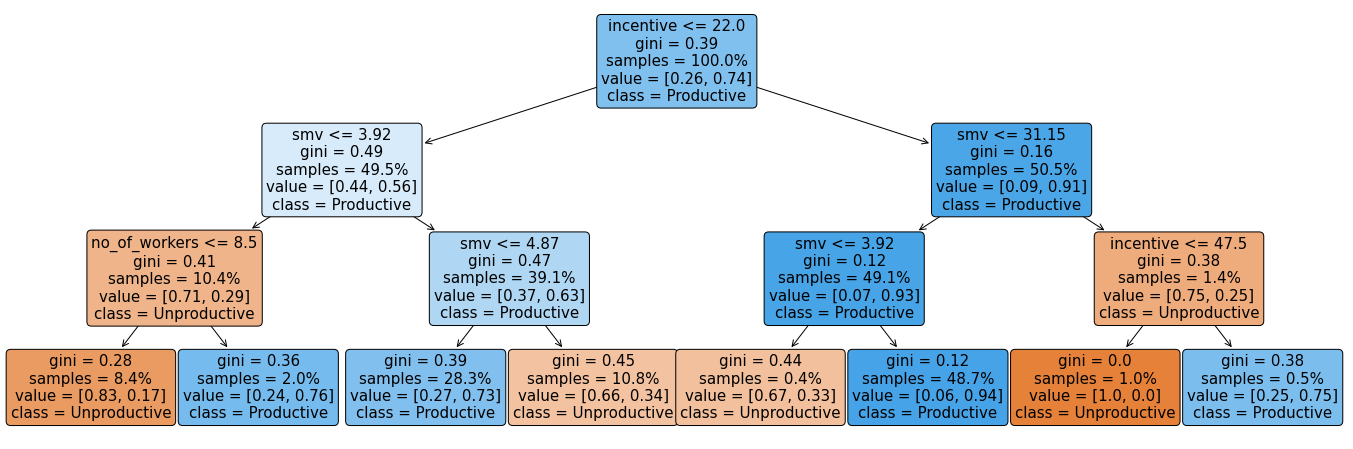

In [114]:
plt.rcParams["figure.figsize"] = [24.0, 8.0]

plot_tree(classification_tree,
 feature_names = X_test.columns,
 class_names = ["Unproductive", "Productive"], 
 filled = True, 
 proportion = True,
 precision = 2,
 rounded = True,
 fontsize = 15)

plt.show()

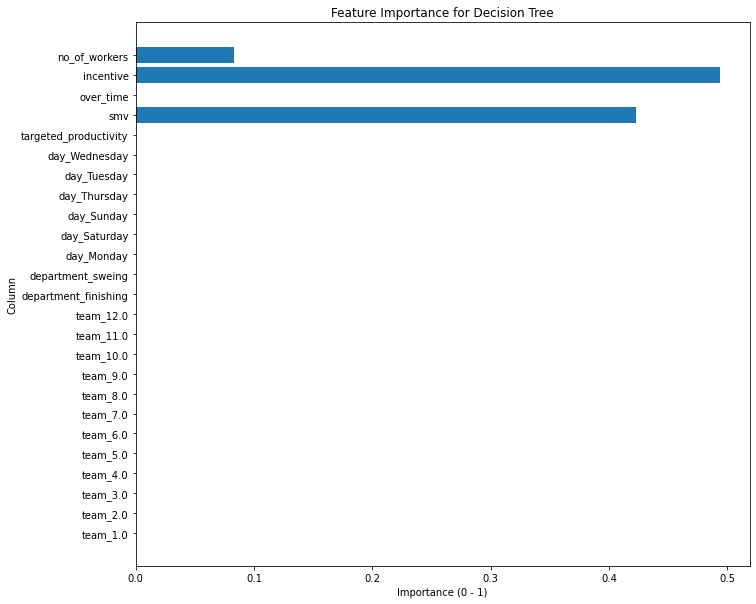

In [115]:
plt.rcParams["figure.figsize"] = [11.0, 10.0]
plt.barh(classification_tree.feature_names_in_, classification_tree.feature_importances_)
plt.xlabel("Importance (0 - 1)")
plt.ylabel("Column")
plt.title("Feature Importance for Decision Tree")
plt.show()

We can see that the most significant columns turned out to be "incentive" and "smv" (standard minute value, the allocated time for a task). Except one, all the splits used these columns to divide the dataset into more subsets. The company should consider to increase the incentives and to lower the smv in some way to improve the productivity.

Now let's take a look at the predictive power metrics.

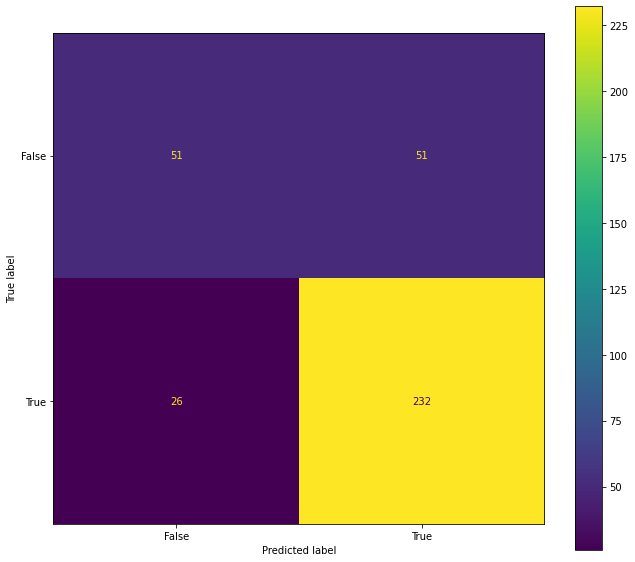

In [116]:
y_pred = classification_tree.predict(X_test)

confusion_matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show() 

It apears that the model is able to predict true labels pretty good, but half of the false labels were predicted wrong.

In [117]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.50      0.57       102
           1       0.82      0.90      0.86       258

    accuracy                           0.79       360
   macro avg       0.74      0.70      0.71       360
weighted avg       0.78      0.79      0.78       360



The recall metric supports our finding from the confusion matrix. Overall the accuracy of the model is 79% for the test set.

We can ensure that this result did not come just by chance of the composition of the test set when we check it by cross validation. It divides the dataset into a number of blocks (determined by the "cv" parameter). Then it creates that many copies of the dataset where each copy will have a different segment of observations compared to the test set. The algorithm will then iterate on each copy and will output a list of the accuracy scores for all iterations.

In [118]:
scores = cross_val_score(classification_tree, X, y, cv = 10)

print("Cross Validation Accuracy Scores:", scores.round(2)) 
print("Mean Cross Validation Score:", scores.mean().round(2))

Cross Validation Accuracy Scores: [0.82 0.86 0.82 0.84 0.85 0.8  0.72 0.74 0.82 0.77]
Mean Cross Validation Score: 0.8


In fact, the predictive power of our model seems to be a little better than expected. It averages 80%.

## Minimal Cost-Complexity Pruning

Pruning is a techniques that is used to solve the problem of overfitting. Pruning, in its literal sense, is a practice which involves the selective removal of certain parts of a tree, to improve the tree’s structure. It makes the tree versatile so that it can adapt if we feed any new data to it, thereby fixing the problem of overfitting.It reduces the size of tree which might slightly increase the training error but drastically decrease the testing error.

The algorithm is parameterized by alpha known as the complexity parameter. Greater values of alpha increase the number of nodes pruned. Sklearn has a function called cost_complexity_pruning_path, which gives the effective alphas of subtrees during pruning. We can use these values of alpha to prune our decision tree.

In [122]:
cost_tree = DecisionTreeClassifier(random_state = 1)
cost_path = cost_tree.cost_complexity_pruning_path(X_train, y_train)

subtrees = []
for alpha in cost_path.ccp_alphas:
    subtree = DecisionTreeClassifier(random_state = 1, ccp_alpha = alpha)
    subtree.fit(X_train, y_train)
    subtrees.append(subtree)
    
ccp_alphas_slice = cost_path.ccp_alphas[-10:-3]
subtrees_slice = subtrees[-10:-3]
subtree_scores = [subtree.score(X_test, y_test) for subtree in subtrees_slice]
alpha_scores = tuple(zip(ccp_alphas_slice, subtree_scores))

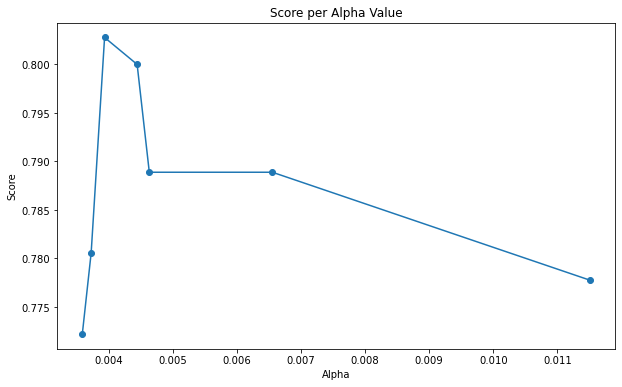

Best alpha, accuracy: (0.003931805973873159, 0.8027777777777778)


In [124]:
plt.rcParams["figure.figsize"] = [10.0, 6.0]
fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Score")
ax.set_title("Score per Alpha Value")
ax.plot(ccp_alphas_slice, subtree_scores, marker="o")
plt.show()

print("Best alpha, accuracy:", max(alpha_scores, key=lambda x:x[1]))

From the plot above, we can see that around alpha=0.004 we get the maximum test accuracy of about 80%. It seems that our original model was already pretty good by coincidence.

## Random Forest

Another common way to confirm the results of a decision tree is the random forest ensemble method. It creats a number of decision tress (default=100), the so called forest. Each of the trees is generated only with random chosen features (not all features like in our model above). By that we taking all of the potential variability in the data into account, this can reduce the risk of overfitting, bias, and overall variance, resulting in more accurate forecasts.

In [121]:
forest = RandomForestClassifier(oob_score = True, random_state = 1)

forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test,y_pred_forest), 2))

Accuracy: 0.79


Since the accuracy of our random forest is similar to the score of our decision tree, we can be confident about our results. To double-check decision trees with a random forest helps us to make sure that the model isn't overfitted.